In [42]:
%matplotlib inline


import pydicom as dicom
import matplotlib.pylab as plt

import os
import numpy as np

In [43]:
def load_CT(PATH):
    slices = [dicom.dcmread(PATH + '/' + s) for s in os.listdir(PATH)]
    return slices
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    image = image.astype(np.int16)
    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [44]:
FOLDER_PATH = "E:/Egyetem/AI/_Orvosi képfeldolgozás/Datasets/positive_lung_CT/tudodaganat/"
featured_cmaps = ["bone","hot","twilight","PuBuGn","inferno","seismic","hsv","twilight_shifted","spring","Accent","bwr","afmhot"  ]

In [45]:
#segmentation:
from skimage import measure, morphology
from skimage.morphology import ball, binary_closing
from skimage.measure import label, regionprops
import cv2
import scipy
from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
import matplotlib.patches as mpatches

def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)
    counts = counts[vals != bg]
    vals = vals[vals != bg]
    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None
def segment_lung_mask(image, fill_lung_structures=True):
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image >= -700, dtype=np.int8)+1
    labels = measure.label(binary_image)
    background_label = labels[0,0,0]
 
    # Fill the air around the person
    binary_image[background_label == labels] = 2
 
    # Method of filling the lung structures (that is superior to 
    # something like morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
 
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
 
    # Remove other air pockets inside body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

def total_lung_MASK(img):
    return 1-scipy.ndimage.filters.gaussian_filter(1-img, 0.7, order=0, output=None, mode='reflect', cval=0.7, truncate=7.0)

def get_internal_structures(dataset):
    segmented_lung = segment_lung_mask(dataset, fill_lung_structures=False)
    return total_lung_MASK(segmented_lung)-segmented_lung

def print_CT_layers_in_table(first, last, dataset, CMAP):
    rows = 1
    columns = 4
    # fig, ax_lst = plt.subplots(2, 2, figsize=(12,8))
    fig = plt.figure(figsize=(30, 30))
    for i in range(first, last):
        if ((i - first) % 4 == 0):
            rows = rows + 1
            fig = plt.figure(figsize=(30, 30))
        fig.add_subplot(1, columns, ((i - first) % 4) + 1)
        plt.axis('off')
        plt.imshow(dataset[i], cmap=CMAP)
        plt.title(str(i) + ".")
    plt.show()



In [46]:
#képátalakító alg-ok:
def segment_frame(image, SIZE):
    thresh = threshold_otsu(image)
    bw = closing(image > thresh, square(3))

    # remove artifacts connected to image border
    cleared = clear_border(bw)

    # label image regions
    label_image = label(cleared)
    # to make the background transparent, pass the value of `bg_label`,
    # and leave `bg_color` as `None` and `kind` as `overlay`
    image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(label_image, cmap= featured_cmaps[4])

    for region in regionprops(label_image):
        # take regions with large enough areas
        if region.area >= SIZE and region.area<100:
            # draw rectangle around segmented coins
            minr, minc, maxr, maxc = region.bbox
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

In [47]:
CT_dicom = load_CT(FOLDER_PATH)
CT_kepsorozat = get_pixels_hu(CT_dicom)
internal = get_internal_structures(CT_kepsorozat)

In [48]:
small_internal=[]
for i in range (100, 105):
    small_internal.append(internal[i])

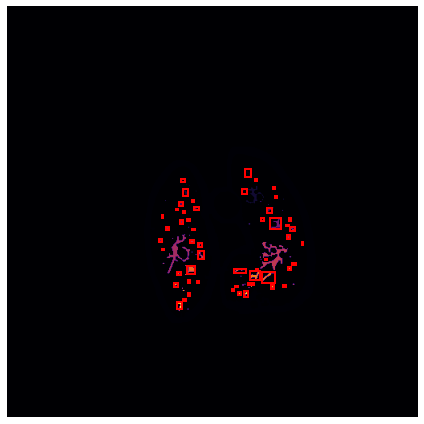

In [49]:
segment_frame(small_internal[3],3)

In [50]:
def get_cropping_size(image, PADDING):
    thresh = threshold_otsu(image)
    bw = closing(image > thresh, square(3))

    # remove artifacts connected to image border
    cleared = clear_border(bw)
    print("called")
    # label image regions
    label_image = label(cleared)
    # to make the background transparent, pass the value of `bg_label`,
    # and leave `bg_color` as `None` and `kind` as `overlay`   
    for region in regionprops(label_image):
        # take regions with large enough areas
        if region.area>500:
            # draw rectangle around segmented coins
            minr, minc, maxr, maxc = region.bbox
            break
    return minr-PADDING, minc-PADDING, maxr+PADDING, maxc+PADDING


def crop_LUNG(image, SCALE, minr, minc, maxr, maxc):
    padding = 20
    #minr, minc, maxr, maxc = get_cropping_size(image, padding)
    crop = image[minr:minr+maxr-minr, minc:minc+maxc-minc]
    scale_percent = 220 # percent of original size
    width = int(crop.shape[1] * SCALE / 100)
    height = int(crop.shape[0] * SCALE / 100)
    dim = (width, height)
    
    crop = np.array(crop, dtype='uint8')

    # resize image
    resized = cv2.resize(crop, dim, interpolation = cv2.INTER_AREA)
    return resized

def crop_LUNG_dataset(dataset, SCALE):
    padding = 20
    minr, minc, maxr, maxc = get_cropping_size(dataset[0], padding)
    
    results = []
    for data in dataset:
        results.append(crop_LUNG(data, SCALE, minr, minc, maxr, maxc))
    return results

called
(1028, 992)
(1028, 992)
(1028, 992)
(1028, 992)
(1028, 992)


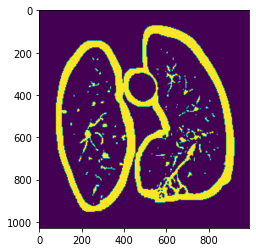

In [51]:
cropped_dataset = crop_LUNG_dataset(small_internal, 400)
for crp in cropped_dataset:
    print(crp.shape)
plt.imshow(cropped_dataset[2])

In [52]:
def sum_pics(dataset):
    dst = dataset[0]
    for i in range(1,len(dataset)-1):
        print("dst = cv2.addWeighted(dst, 0.5, dataset[{}], 0.5, 0.0)".format(i))
        dst = cv2.addWeighted(dst, 0.5, dataset[i], 0.5, 0.0)
    return dst

dst = cv2.addWeighted(dst, 0.5, dataset[1], 0.5, 0.0)
dst = cv2.addWeighted(dst, 0.5, dataset[2], 0.5, 0.0)
dst = cv2.addWeighted(dst, 0.5, dataset[3], 0.5, 0.0)


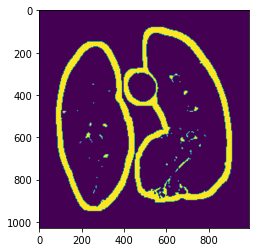

In [53]:
sum_pic = sum_pics(cropped_dataset)
plt.imshow(sum_pic)

sum_p = sum_pic

In [54]:
def aboutSQ(a, b, REGION_AREA, TRESHOLD, AREA_TRESHOLD_PERCENT):
    #if the frame is circle enough:
    smaller = min(a,b)
    smallerarea = pow(smaller/2,2)*math.pi
    if(abs(a-b)<TRESHOLD and smallerarea>REGION_AREA*AREA_TRESHOLD_PERCENT):
        print("smallerarea: {}, REGION_AREA{}".format(smallerarea, REGION_AREA))
        print("SUCCESS")
        return True
    else:
        return False

In [111]:
#JÓ SZEGMENTÁLÁS!
import math

def segment_frame_plot(image, MINSIZE, MAXSIZE, PADDING):
    thresh = threshold_otsu(image)
    bw = closing(image > thresh, square(3))
    cntr = 0
    # remove artifacts connected to image border
    cleared = clear_border(bw)

    # label image regions
    label_image = label(cleared)
    # to make the background transparent, pass the value of `bg_label`,
    # and leave `bg_color` as `None` and `kind` as `overlay`
    image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(image)
    
    for region in regionprops(label_image):
        # take regions with large enough areas
        if region.area >= MINSIZE and region.area<MAXSIZE:
            # draw rectangle around segmented coins
            minr, minc, maxr, maxc = region.bbox
            #if the frame is circle enough:
            if(aboutSQ(maxc - minc, maxr - minr,region.area,40,0.67)):
            #if(True):
                rect = mpatches.Rectangle((minc-PADDING, minr-PADDING), maxc - minc+PADDING*2, maxr - minr+PADDING*2,
                                          fill=False, edgecolor='blue', linewidth=1)
                cntr+=1
                ax.add_patch(rect)
                #print("x= {}, y = {}, w = {}, h = {}, rectangle size = ".format(minr, minc, maxr, maxc))
                print(cntr)
                ax.annotate("Rectangle{}".format(cntr), (minc-10, minr-10), color='white', weight='bold', fontsize=5, ha='left', va='center')

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

smallerarea: 1256.6370614359173, REGION_AREA432
SUCCESS
1
smallerarea: 314.1592653589793, REGION_AREA272
SUCCESS
2
smallerarea: 314.1592653589793, REGION_AREA272
SUCCESS
3
smallerarea: 113.09733552923255, REGION_AREA128
SUCCESS
4
smallerarea: 113.09733552923255, REGION_AREA128
SUCCESS
5
smallerarea: 201.06192982974676, REGION_AREA240
SUCCESS
6
smallerarea: 201.06192982974676, REGION_AREA128
SUCCESS
7
smallerarea: 452.3893421169302, REGION_AREA400
SUCCESS
8
smallerarea: 201.06192982974676, REGION_AREA128
SUCCESS
9
smallerarea: 314.1592653589793, REGION_AREA240
SUCCESS
10
smallerarea: 314.1592653589793, REGION_AREA288
SUCCESS
11
smallerarea: 50.26548245743669, REGION_AREA64
SUCCESS
12
smallerarea: 50.26548245743669, REGION_AREA64
SUCCESS
13
smallerarea: 113.09733552923255, REGION_AREA80
SUCCESS
14
smallerarea: 201.06192982974676, REGION_AREA208
SUCCESS
15
smallerarea: 50.26548245743669, REGION_AREA64
SUCCESS
16


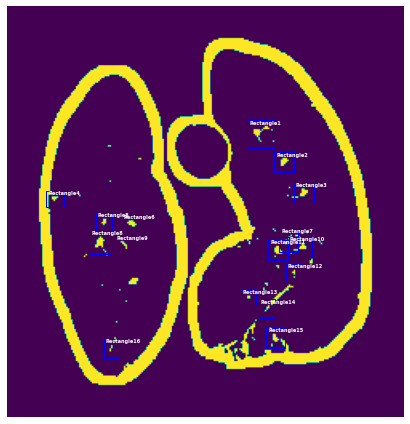

In [112]:
segment_frame_plot(sum_p,50, 500, 15)

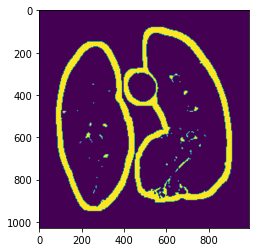

In [35]:
plt.imshow(sum_p)

smallerarea: 1385.4423602330987, REGION_AREA382
SUCCESS
1
smallerarea: 28.274333882308138, REGION_AREA56
smallerarea: 28.274333882308138, REGION_AREA56
smallerarea: 380.132711084365, REGION_AREA152
SUCCESS
2
smallerarea: 380.132711084365, REGION_AREA148
SUCCESS
3
smallerarea: 153.93804002589985, REGION_AREA114
SUCCESS
4
smallerarea: 28.274333882308138, REGION_AREA104
smallerarea: 153.93804002589985, REGION_AREA114
SUCCESS
5
smallerarea: 254.46900494077323, REGION_AREA156
SUCCESS
6
smallerarea: 78.53981633974483, REGION_AREA62
SUCCESS
7
smallerarea: 254.46900494077323, REGION_AREA198
SUCCESS
8
smallerarea: 78.53981633974483, REGION_AREA86
smallerarea: 530.929158456675, REGION_AREA222
SUCCESS
9
smallerarea: 254.46900494077323, REGION_AREA150
SUCCESS
10
smallerarea: 78.53981633974483, REGION_AREA62
SUCCESS
11
smallerarea: 380.132711084365, REGION_AREA222
SUCCESS
12
smallerarea: 28.274333882308138, REGION_AREA56
smallerarea: 380.132711084365, REGION_AREA148
SUCCESS
13
smallerarea: 78.53981

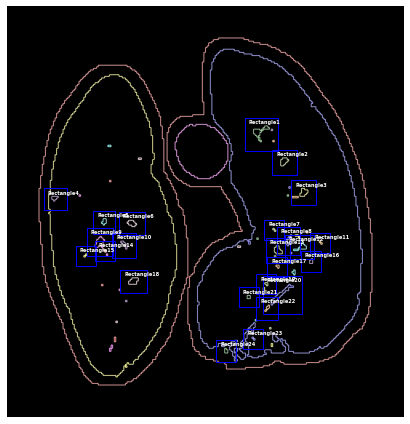

In [36]:
gx, gy = np.gradient(sum_p)
temp_edge = gy * gy + gx * gx
temp_edge[temp_edge != 0.0] = 255.0
temp_edge = np.asarray(temp_edge, dtype=np.uint8)
#plt.imshow(temp_edge)
segment_frame_plot(temp_edge,50, 500, 20)

In [109]:
def segment_frame_image(image, MINSIZE, MAXSIZE):
    thresh = threshold_otsu(image)
    bw = closing(image > thresh, square(3))
    first = True
    # remove artifacts connected to image border
    cleared = clear_border(bw)
    img = image.copy()
    # label image regions
    label_image = label(cleared)
    frames = []
    # to make the background transparent, pass the value of `bg_label`,
    # and leave `bg_color` as `None` and `kind` as `overlay`
    image_label_overlay = label2rgb(label_image, image=image, bg_label=0)    
    for region in regionprops(label_image):
        # take regions with large enough areas
        
        if region.area >= MINSIZE and region.area<MAXSIZE:
            # draw rectangle around segmented coins
            rectangle = []
            minr, minc, maxr, maxc = region.bbox
            #rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='blue', linewidth=1)
            frames.append(cv2.rectangle(img, (minc, minr), (maxc, maxr), (100, 0, 255), 10))
            rectangle.append()
            print(len(frames))
    return frames

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


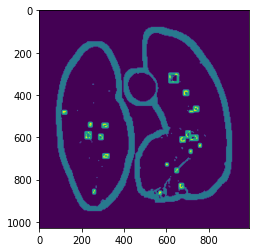

In [110]:
all_frames = segment_frame_image(sum_pic,50, 500)

for frame in all_frames:
    sm=cv2.addWeighted(sum_pic, 7,frame, 0.1, 0.0)
plt.imshow(sm)

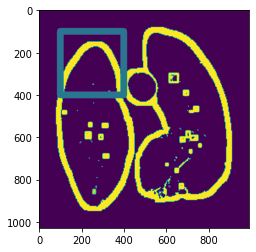

In [93]:
rectangled_image = segment_frame_image(sum_pic,50, 500)
fram = cv2.rectangle(rectangled_image, (100, 100), (400, 400), (100, 25, 255), 30)
#rectangled_image = cv2.rectangle(rectangled_image, (33, 3), (800, 800), (255, 0, 0), 10)
plt.imshow(fram)

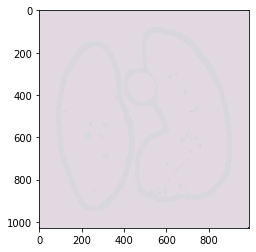

In [18]:
dstn=cv2.addWeighted(sum_pic, 7,rectangled_image, 0.1, 0.0)
plt.imshow(dstn, cmap= featured_cmaps[2])

In [19]:
def get_all_framed(dataset):
    results_dataset = []
    for data in dataset:
        d=cv2.addWeighted(data, 7,segment_frame_image(data,50, 500), 0.1, 0.0)
        results_dataset.append(d)
    return results_dataset

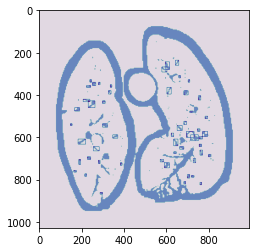

In [20]:
all_CT = get_all_framed(cropped_dataset)
plt.imshow(all_CT[1], cmap= featured_cmaps[2])


In [21]:
import imageio
from IPython import display

def make_a_GIF(imgs, GIFNAME):
    imageio.mimsave(f'./{GIFNAME}.gif', imgs, duration=0.1)
    display.Image(f'./{GIFNAME}.gif', format='png')


In [22]:
#make_a_GIF(all_CT, "framed_lungi")